Classification with logistic regession on the balanced dataset split by donors.
 - This is a baseline to assess performance of more complex models. 
 - Here here is no mitigation of batch effects; next iteration can consider a binning strategy.
 - Overall accuracy is ~0.89.

In [1]:
import numpy as np
import anndata as ad
import scanpy as sc
from sklearn.model_selection import train_test_split
from schelp.utils.config import load_config
from rich import print as rprint
import pandas as pd
from schelp.utils.data import add_scgpt_data_columns

import matplotlib.pyplot as plt
import seaborn as sns

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=0.8, rc=custom_params)
%config InlineBackend.figure_format='retina'


paths = load_config(dataset_key="init")
adata_train = ad.read_h5ad(paths["data"] / "Human-Brain/v1_donor_split_train.h5ad")
adata_test = ad.read_h5ad(paths["data"] / "Human-Brain/v1_donor_split_test.h5ad")
adata_train, num_types, id2type, celltypes = add_scgpt_data_columns(adata_train)
adata_test, _, _, celltypes_test = add_scgpt_data_columns(adata_test)

In [2]:
# pipeline for logistic regression classifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline

# split the data into train and test
X_train = adata_train.X.A
y_train = adata_train.obs["celltype_id"]
X_test = adata_test.X.A
y_test = adata_test.obs["celltype_id"]

# create a pipeline
pipe = Pipeline([("scaler", StandardScaler()), ("clf", LogisticRegression())])

# fit the pipeline
pipe.fit(X_train, y_train)

# predict the test set
y_pred = pipe.predict(X_test)

# print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall test accuracy: {accuracy:0.3f}")

Overall test accuracy: 0.852


In [3]:
# rprint(classification_report(y_test, y_pred, target_names=celltypes))
report = classification_report(y_test, y_pred, target_names=celltypes, output_dict=True)
df = pd.DataFrame(report).transpose()

# round entries to 3 decimal places
df = pd.DataFrame(report).transpose()
display(df.tail(3))

# display full dataframe
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

# reorder rows to match the order of celltypes
df = df.reindex(celltypes.categories.tolist())


# color any values less than 0.5
def color_negative_red(val):
    color = "#ff9999" if val < 0.5 else "black"
    return "color: %s" % color


display(df.round(3).style.map(color_negative_red))

,precision,recall,f1-score,support
accuracy,0.851806,0.851806,0.851806,0.851806
macro avg,0.818921,0.881477,0.838143,165668.000000
weighted avg,0.879630,0.851806,0.858178,165668.000000


,precision,recall,f1-score,support
Astro_1,0.887000,0.774000,0.827000,3769.000000
Astro_2,0.650000,0.885000,0.749000,1179.000000
Astro_3,0.809000,0.853000,0.830000,936.000000
Astro_4,0.952000,0.983000,0.967000,181.000000
Astro_5,0.989000,0.971000,0.980000,751.000000
Astro_6-SEAAD,0.957000,1.000000,0.978000,333.000000
Chandelier_1,0.617000,0.728000,0.668000,2102.000000
Chandelier_2,0.569000,0.860000,0.685000,178.000000
Endo_1,0.968000,0.913000,0.940000,1097.000000
Endo_2,0.856000,0.945000,0.898000,472.000000


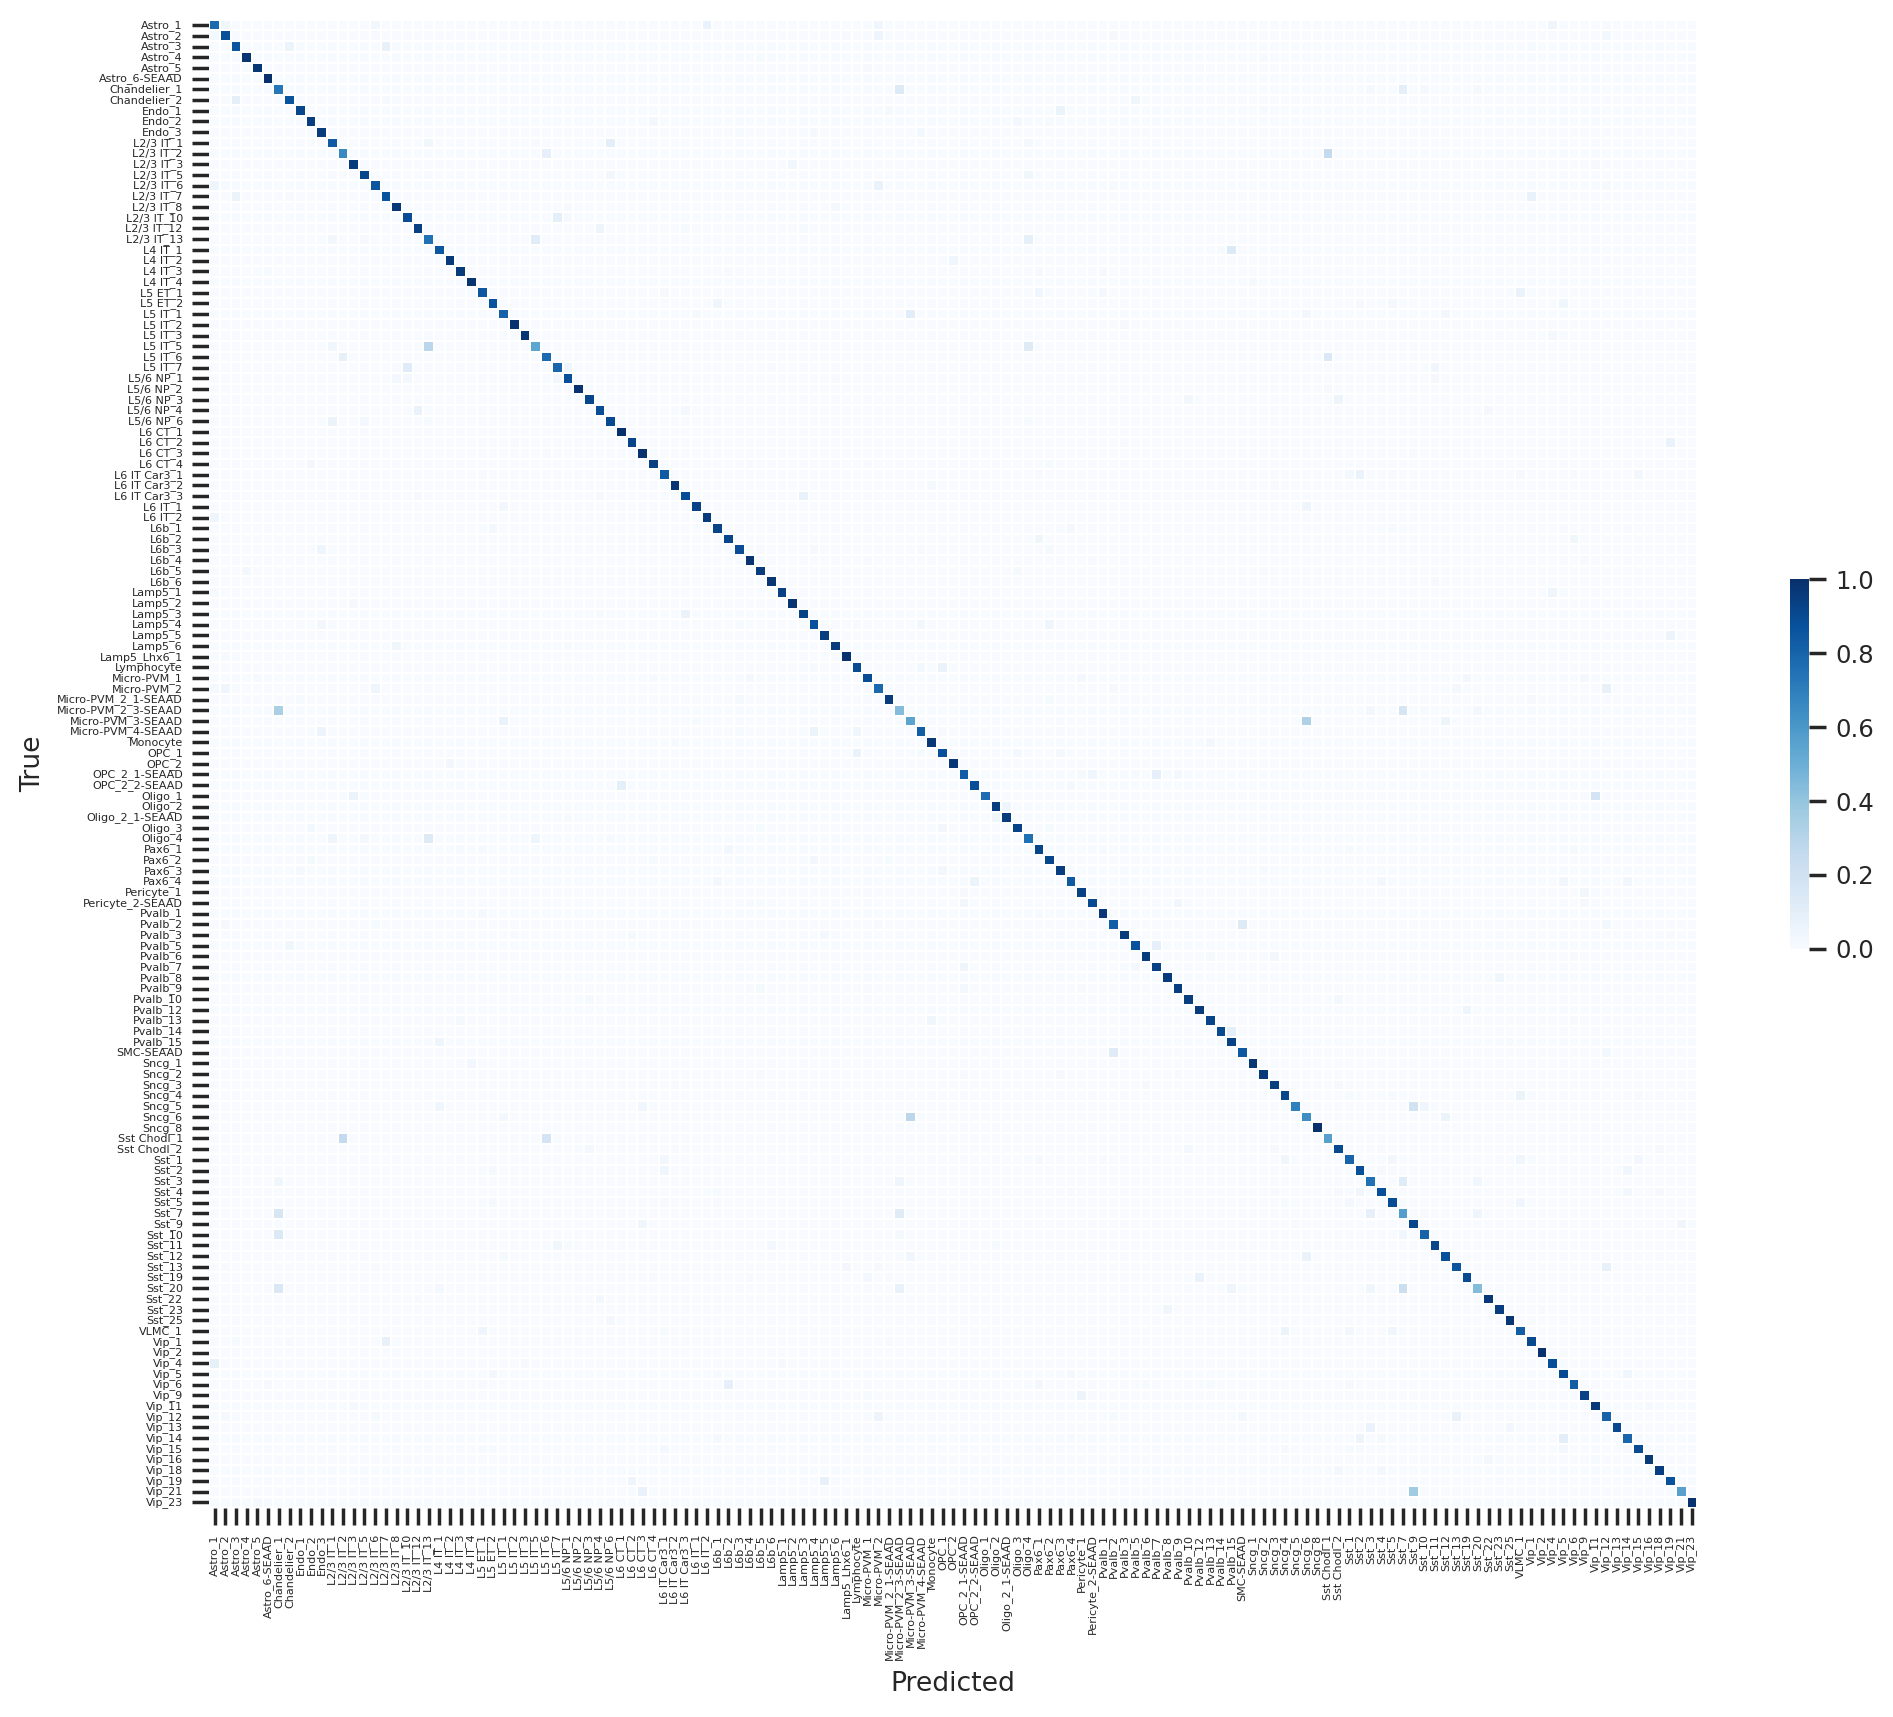

In [4]:
cm = confusion_matrix(y_test.values, y_pred, normalize="true")
cm = pd.DataFrame(cm, index=celltypes[: cm.shape[0]], columns=celltypes[: cm.shape[1]])

ordered_names = adata_train.obs["Supertype"].cat.categories.tolist()
values = np.zeros((len(ordered_names), len(ordered_names))) * np.nan

df = pd.DataFrame(values, index=ordered_names, columns=ordered_names)
# fill in available values in cm
for col_name in cm.columns:
    for row_name in cm.index:
        df.loc[row_name, col_name] = cm[col_name][row_name]

f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    df,
    cmap="Blues",
    annot=False,
    fmt=".2f",
    annot_kws={"size": 5},
    vmin=0,
    vmax=1,
    ax=ax,
    linewidths=0.1,
    square=True,
    cbar_kws={"shrink": 0.2},
    xticklabels=1,
    yticklabels=1,
)
ax.set(xlabel="Predicted", ylabel="True")
plt.xticks(fontsize=4)
plt.yticks(fontsize=4)
plt.show()